<a href="https://colab.research.google.com/github/AlifeviousChristian/Batteries-State-Of-Health-Estimation/blob/main/LSTM_Charging75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation of The Dataset

In [33]:
# To install the kaggle connnector

!pip install kaggle

In [34]:
# To allow the GDrive connection to this notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# This is to configure that our dataset will be saved at /content/drive/MyDrive/Thesis

import os
os.chdir("/content/drive/MyDrive/Thesis")

## Analyzing the data and creating the LSTM model
Refer to https://youtu.be/c0k-YLQGKjY?si=7rK46NGHURBgLNE2

In [36]:
# This is to import all necesary libraries

import tensorflow as tf
import pandas as pd
import numpy as np

In [37]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/75SOCDatasetOnly.csv") #Based on the dataset information, all value is in MWs
df

,No,SoC,Unnamed: 2
0,0.0,72.39,NaN
1,1.0,73.13,NaN
2,2.0,73.13,NaN
3,3.0,85.07,NaN
4,4.0,85.82,NaN
...,...,...,...
164,164.0,100.00,NaN
165,165.0,99.25,NaN
166,166.0,100.75,NaN
167,167.0,100.00,NaN


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df

,No,SoC,Unnamed: 2
0,0.0,72.39,NaN
1,1.0,73.13,NaN
2,2.0,73.13,NaN
3,3.0,85.07,NaN
4,4.0,85.82,NaN
...,...,...,...
164,164.0,100.00,NaN
165,165.0,99.25,NaN
166,166.0,100.75,NaN
167,167.0,100.00,NaN


<Axes: >

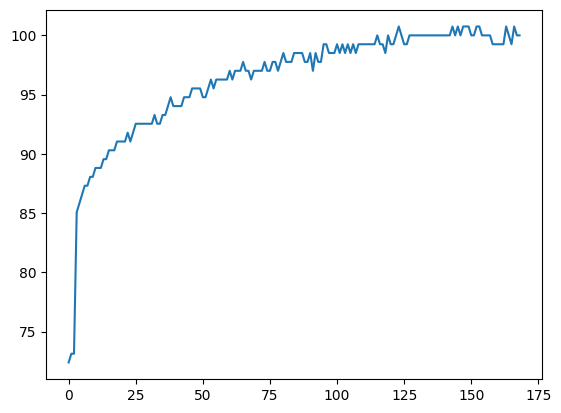

In [40]:
elec = df['SoC'] # All values devided by 1000 to normalize the data since our the data is quite big
elec.plot() # Plot the dataset

In [41]:
# We are going to create a matrix like bellow :
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [42]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(elec, WINDOW_SIZE)
X1.shape, y1.shape

((166, 3, 1), (166,))

In [43]:
# This is to devide the dataset into train, validation, and test set.

X_train1, y_train1 = X1[:120], y1[:120]
X_val1, y_val1 = X1[120:150], y1[120:150]
X_test1, y_test1 = X1[150:], y1[150:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((120, 3, 1), (120,), (30, 3, 1), (30,), (16, 3, 1), (16,))

In [44]:
# Creating a LSTM model using tensorflow-keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model3 = Sequential()
model3.add(InputLayer((3, 1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Configuring the optimizer

cp1 = ModelCheckpoint('model3/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history=model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp1])
model3.save('model3/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - loss: 9135.9648 - root_mean_squared_error: 95.5812 - val_loss: 9923.6787 - val_root_mean_squared_error: 99.6177
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 9041.2939 - root_mean_squared_error: 95.0852 - val_loss: 9885.5693 - val_root_mean_squared_error: 99.4262
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8962.8555 - root_mean_squared_error: 94.6723 - val_loss: 9845.3555 - val_root_mean_squared_error: 99.2238
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 8930.1582 - root_mean_squared_error: 94.4995 - val_loss: 9810.9746 - val_root_mean_squared_error: 99.0504
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 8960.6055 - root_mean_squared_error: 94.6599 - val_loss: 9775.7832 - val_root_mean_squared_error: 98.8726
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 8858.3125 - root_mean_squared_error: 94.1185 - val_loss: 9740.5684 - val_root_mean_squared_error: 98.6943
Epoch 7/500
4

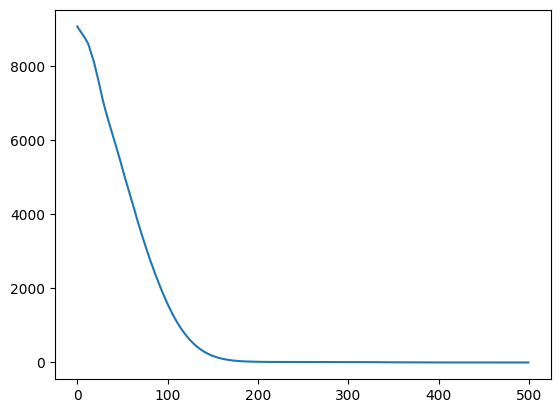

In [46]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model3 = load_model('model3/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [47]:
train_predictions = model3.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train predictions':train_predictions, 'Actuals':y_train1})
train_results['Error'] = abs(train_results['Actuals'] - train_results['Train predictions'])
train_results['Percentage Error (%)'] = (train_results['Error'] / train_results['Actuals']) * 100
train_results

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


,Train predictions,Actuals,Error,Percentage Error (%)
0,83.978065,85.07,1.091935,1.283572
1,86.049255,85.82,0.229255,0.267135
2,87.386078,86.57,0.816078,0.942680
3,87.605087,87.31,0.295087,0.337976
4,88.069382,87.31,0.759382,0.869753
...,...,...,...,...
115,99.057724,98.51,0.547724,0.556009
116,98.824493,100.00,1.175507,1.175507
117,99.174805,99.25,0.075195,0.075764
118,99.174347,99.25,0.075653,0.076225


In [48]:
import matplotlib.pyplot as plt


avg_error = train_results['Error'].mean()
max_error = train_results['Error'].max()
min_error = train_results['Error'].min()

print(f"Average Error: {avg_error}")
print(f"Maximum Error: {max_error}")
print(f"Minimum Error: {min_error}")

Average Error: 0.4508336664835601
Maximum Error: 1.4550268554687449
Minimum Error: 0.008965454101556247


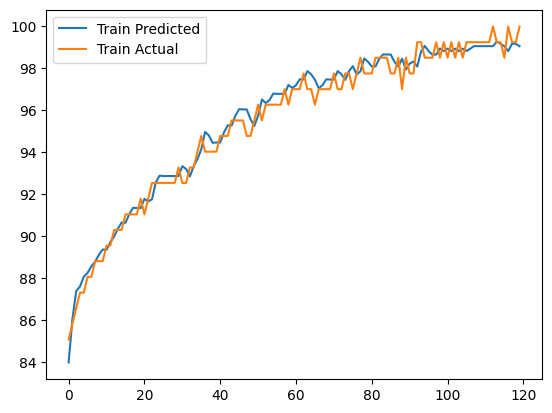

In [49]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train predictions'], label='Train Predicted')
plt.plot(train_results['Actuals'], label='Train Actual')
plt.legend()

In [50]:
val_predictions = model3.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val predictions':val_predictions, 'Actuals':y_val1})
val_results['Error val'] = abs(val_results['Actuals'] - val_results['Val predictions'])
val_results['Percentage Error val (%)'] = (val_results['Error val'] / val_results['Actuals']) * 100
val_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


,Val predictions,Actuals,Error val,Percentage Error val (%)
0,99.284683,100.75,1.465317,1.454409
1,99.581268,100.00,0.418732,0.418732
2,99.470993,99.25,0.220993,0.222663
3,99.163231,99.25,0.086769,0.087425
4,99.057724,100.00,0.942276,0.942276
5,99.284683,100.00,0.715317,0.715317
6,99.384621,100.00,0.615379,0.615379
7,99.381203,100.00,0.618797,0.618797
8,99.381203,100.00,0.618797,0.618797
9,99.381203,100.00,0.618797,0.618797


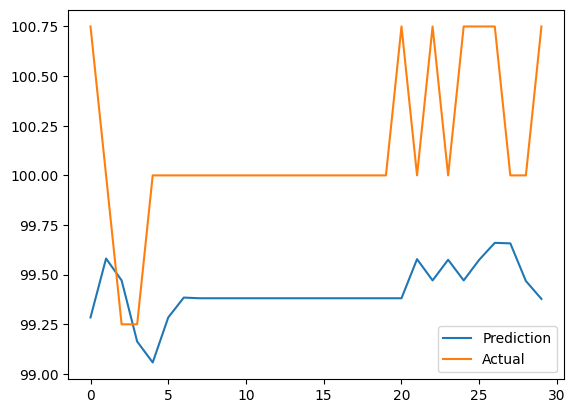

In [51]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val predictions'][:1000], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(val_results['Actuals'][:1000], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

In [52]:
test_predictions = model3.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test predictions':test_predictions, 'Actuals':y_test1})
test_results['Error test'] = abs(test_results['Actuals'] - test_results['Test predictions'])
test_results['Percentage Error val (%)'] = (test_results['Error test'] / val_results['Actuals']) * 100
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


,Test predictions,Actuals,Error test,Percentage Error val (%)
0,99.578140,100.75,1.171860,1.163136
1,99.660278,100.00,0.339722,0.339722
2,99.468117,100.00,0.531883,0.535903
3,99.377884,100.00,0.622116,0.626817
4,99.381203,100.00,0.618797,0.618797
5,99.381203,99.25,0.131203,0.131203
6,99.166840,99.25,0.083160,0.083160
7,99.057724,99.25,0.192276,0.192276
8,99.061966,99.25,0.188034,0.188034
9,99.061966,99.25,0.188034,0.188034


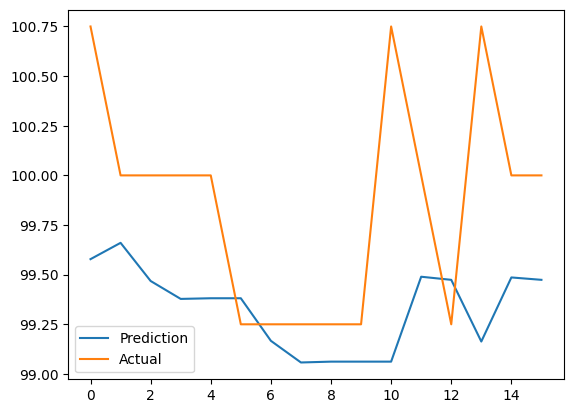

In [53]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

Analyzing the data and creating the CNN model

## Analyzing the data and creating the CNN model
Refer to https://www.youtube.com/watch?v=kGdbPnMCdOg&t=1320s

In [54]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=7800):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['Predictions', 'Actuals'])
    return df, mse(y, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


(    Predictions  Actuals
 0     99.578140   100.75
 1     99.660278   100.00
 2     99.468117   100.00
 3     99.377884   100.00
 4     99.381203   100.00
 5     99.381203    99.25
 6     99.166840    99.25
 7     99.057724    99.25
 8     99.061966    99.25
 9     99.061966    99.25
 10    99.061966   100.75
 11    99.489578   100.00
 12    99.473969    99.25
 13    99.163231   100.75
 14    99.486000   100.00
 15    99.473969   100.00,
 0.5557631471056084)

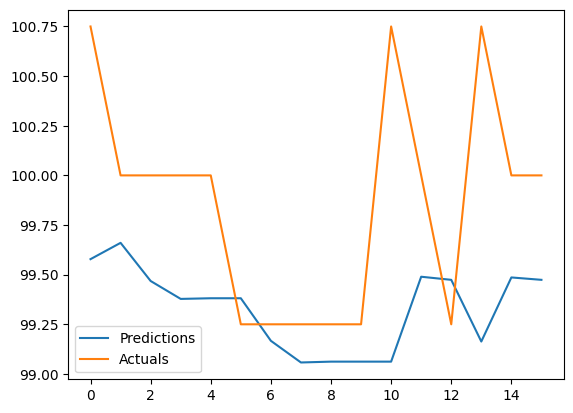

In [55]:
plot_predictions(model3, X_test1, y_test1)

In [56]:
model4 = Sequential()
model4.add(InputLayer((3, 1)))
model4.add(Conv1D(64, kernel_size = 2))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233 (4.82 KB)

 Trainable params: 1,233 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Configuring the optimizer

cp2 = ModelCheckpoint('model4/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2=model4.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp2])
model4.save('model4/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 9795.4414 - root_mean_squared_error: 98.9360 - val_loss: 7497.0601 - val_root_mean_squared_error: 86.5856
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6149.3447 - root_mean_squared_error: 78.3723 - val_loss: 4350.9746 - val_root_mean_squared_error: 65.9619
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3562.8635 - root_mean_squared_error: 59.6573 - val_loss: 2685.9912 - val_root_mean_squared_error: 51.8265
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2251.0000 - root_mean_squared_error: 47.4228 - val_loss: 1651.2391 - val_root_mean_squared_error: 40.6354
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1350.9863 - root_mean_squared_error: 36.7304 - val_loss: 873.1660 - val_root_mean_squared_error: 29.5494
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 691.1867 - root_mean_squared_error: 26.2618 - val_loss: 360.5768 - val_root_mean_squared_error: 18.9889
Epoch 7/500
4/4 ━━━

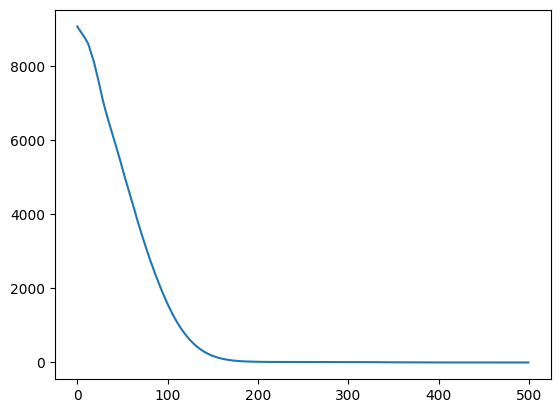

In [58]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model4 = load_model('model4/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [59]:
test_predictions2 = model4.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test predictions':test_predictions2, 'Actuals':y_test1})
test_results2['Error test'] = test_results2['Actuals'] - test_results2['Test predictions']
test_results2['Percentage Error test (%)'] = (test_results2['Error test'] / test_results2['Actuals']) * 100
test_results2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


,Test predictions,Actuals,Error test,Percentage Error test (%)
0,100.587250,100.75,0.162750,0.161539
1,100.819534,100.00,-0.819534,-0.819534
2,100.767647,100.00,-0.767647,-0.767647
3,100.535355,100.00,-0.535355,-0.535355
4,100.302567,100.00,-0.302567,-0.302567
5,100.302567,99.25,-1.052567,-1.060520
6,100.017868,99.25,-0.767868,-0.773671
7,99.785553,99.25,-0.535553,-0.539600
8,99.552765,99.25,-0.302765,-0.305053
9,99.552765,99.25,-0.302765,-0.305053


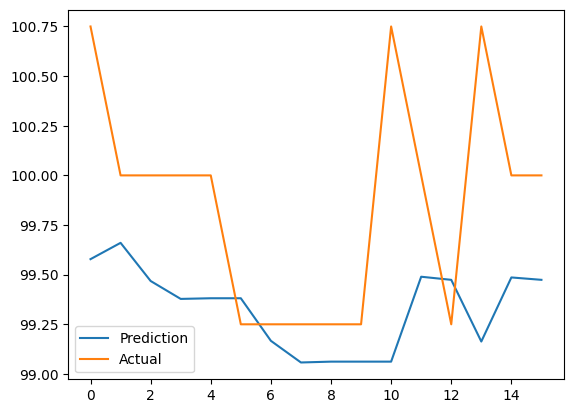

In [60]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


(    Predictions  Actuals
 0    100.587250   100.75
 1    100.819534   100.00
 2    100.767647   100.00
 3    100.535355   100.00
 4    100.302567   100.00
 5    100.302567    99.25
 6    100.017868    99.25
 7     99.785553    99.25
 8     99.552765    99.25
 9     99.552765    99.25
 10    99.552765   100.75
 11   100.122162   100.00
 12   100.302055    99.25
 13   100.250664   100.75
 14   100.354950   100.00
 15   100.302055   100.00,
 0.4284315029217396)

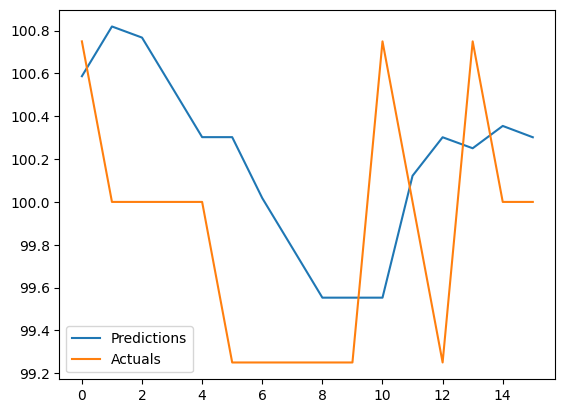

In [61]:
plot_predictions(model4, X_test1, y_test1)

In [62]:
import matplotlib.pyplot as plt

avg_error = test_results2['Percentage Error test (%)'].mean()
max_error = test_results2['Percentage Error test (%)'].max()
min_error = test_results2['Percentage Error test (%)'].min()

print(f"Average Error: {abs(avg_error)}","%")
print(f"Maximum Error: {max_error}","%")
print(f"Minimum Error: {abs(min_error)}","%")

Average Error: 0.3376681797608337 %
Maximum Error: 1.1883226872673698 %
Minimum Error: 1.06052043155699 %


Analyzing